# Downloading SAMOS data from MarineFlux ERDDAP server

In [71]:
from erddapy import ERDDAP
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy.ma as ma
import numpy as np

## Create the ERDDAP request

In [ ]:
extent = [280.0, 290.0, 30.0, 40.0] # [lon-, lon+, lat-, lat+]
flux_algorithms = ["S88", "B23", "C36"]
start_time = "2021-01-01T00:00:00Z"
end_time = "2022-02-01T00:00:00Z"
min_wind_speed = 2.0
z_over_L_min = -0.6
z_over_L_max = 0.6

In [73]:
erddap_samos = dict()
for algo in flux_algorithms:
  erddap_samos[algo] = ERDDAP(
    server="http://erddap-samos.coaps.fsu.edu/erddap",
    protocol="tabledap",
  )

  erddap_samos[algo].dataset_id = f"SAMOS_Fluxes_{algo}_20240624"
  erddap_samos[algo].constraints = {
      "time>=": start_time,
      "time<=": end_time,
      "in_SPD>": min_wind_speed
  }
  erddap_samos[algo].variables = [
      "z_over_L"
  ]

## Request data as xarray Dataset

In [74]:
ds = dict()

for algo in flux_algorithms:
    ds[algo] = erddap_samos[algo].to_xarray()

    print(ds[algo])

<xarray.Dataset>
Dimensions:    (row: 229231)
Coordinates:
    longitude  (row) float32 ...
    latitude   (row) float32 ...
    time       (row) datetime64[ns] ...
Dimensions without coordinates: row
Data variables:
    z_over_L   (row) float64 ...
Attributes: (12/39)
    acknowledgement:           NOAA/CPO/COM via award NA21OAR4310262
    cdm_data_type:             Point
    comment:                   These data are all of the input variables and ...
    Conventions:               COARDS, CF-1.6, ACDD-1.3
    creator_name:              Marine Data Center, Center for Ocean-Atmospher...
    creator_type:              institution
    ...                        ...
    subsetVariables:           platform_name
    summary:                   SAMOS Air-Sea Fluxes - S88. These data are all...
    time_coverage_end:         2021-02-01T00:00:00Z
    time_coverage_start:       2021-01-01T00:00:00Z
    title:                     SAMOS Air-Sea Fluxes - S88
    Westernmost_Easting:       0.0
<xarr

### z/L plotted as a function of time

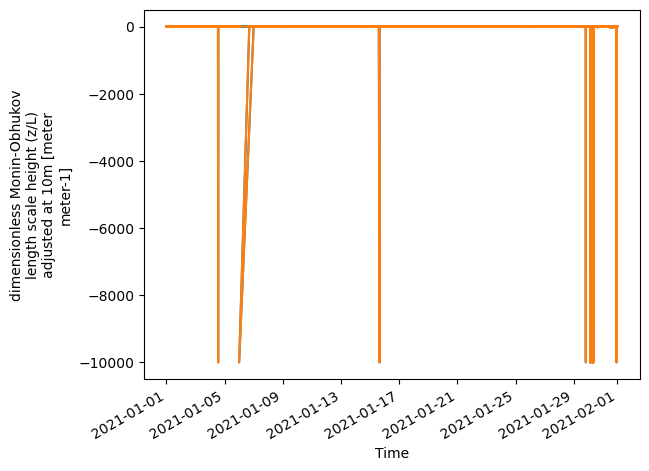

In [75]:
for algo in flux_algorithms:
    ds[algo]['z_over_L'].plot(x='time')

### z/L histogram

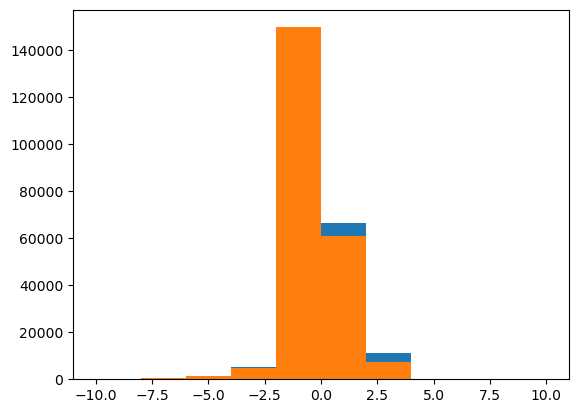

In [76]:
for algo in flux_algorithms:
    plt.hist(ds[algo]['z_over_L'], range=[-10,10])

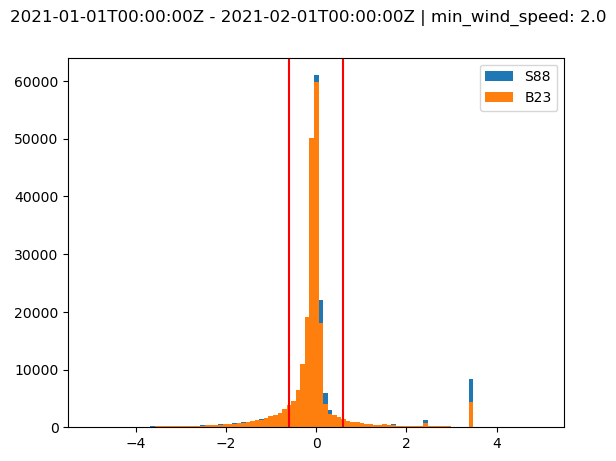

In [77]:
for algo in flux_algorithms:
    plt.hist(ds[algo]['z_over_L'], bins=np.linspace(-5, 5, 100), label=algo)

ax = plt.gca()
plt.vlines([z_over_L_min, z_over_L_max], 0, 1, transform=ax.get_xaxis_transform(), colors='r')
plt.suptitle(f'{start_time} - {end_time} | min_wind_speed: {min_wind_speed}')
plt.legend()

In [78]:
for algo in flux_algorithms:
    over = np.where(ds[algo]['z_over_L'] > z_over_L_max)[0]
    under = np.where(ds[algo]['z_over_L'] < z_over_L_min)[0]
    total = len(ds[algo]['z_over_L'])
    print(f'{algo = }')
    print(f'z/L below {z_over_L_min}: {(100*len(under) / total):.2f}%')
    print(f'z/L above {z_over_L_max}: {(100*len(over) / total):.2f}%')
    print(f'z/L out of bounds: {(100*(len(over) + len(under)) / total):.2f}%')

algo = 'S88'
z/L below -0.6: 12.55%
z/L above 0.6: 8.40%
z/L out of bounds: 20.96%
algo = 'B23'
z/L below -0.6: 12.19%
z/L above 0.6: 6.84%
z/L out of bounds: 19.03%
